# Part-of-Speech Tagging using Recurrent Neural Networks (RNN and LSTM)
Author: Pierre Nugues

A part-of-speech tagger using recurrent networks and GloVe embeddings and trained on a corpus following the Universal Dependencies format. Here we use the English Web Treebank:
https://github.com/UniversalDependencies/UD_English-EWT/tree/master.

## Python Headers

### The Modules

In [1]:
import sys
import os
from sklearn.feature_extraction import DictVectorizer
import time
from keras import models, layers
import sys
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import load_model
import math
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import LSTM, Bidirectional, SimpleRNN, Dense, Embedding
import matplotlib.pyplot as plt

### Some Parameters

In [2]:
OPTIMIZER = 'rmsprop'
BATCH_SIZE = 128
EPOCHS = 10
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 150
LSTM_UNITS = 512
MINI_CORPUS = False

## Preprocessing

### Loading the Embeddings
We will use GloVe embeddings and load them

In [3]:
def load(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    file = file
    embeddings = {}
    glove = open(file)
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    embeddings_dict = embeddings
    embedded_words = sorted(list(embeddings_dict.keys()))
    return embeddings_dict

In [4]:
embedding_file = '/Users/pierre/Documents/Cours/EDAN20/corpus/glove.6B.100d.txt'
embeddings_dict = load(embedding_file)

In [5]:
embeddings_dict['table']

array([-0.61454  ,  0.89693  ,  0.56771  ,  0.39102  , -0.22437  ,
        0.49035  ,  0.10868  ,  0.27411  , -0.23833  , -0.52153  ,
        0.73551  , -0.32654  ,  0.51304  ,  0.32415  , -0.46709  ,
        0.68051  , -0.25497  , -0.040484 , -0.54418  , -1.0548   ,
       -0.46692  ,  0.23557  ,  0.31234  , -0.34537  ,  0.14793  ,
       -0.53745  , -0.43215  , -0.48724  , -0.51019  , -0.9051   ,
       -0.17919  , -0.018376 ,  0.09719  , -0.31623  ,  0.7512   ,
        0.92236  , -0.49965  ,  0.14036  , -0.28296  , -0.97443  ,
       -0.0094408, -0.62944  ,  0.14711  , -0.94376  ,  0.0075222,
        0.18565  , -0.99172  ,  0.072789 , -0.18474  , -0.52901  ,
        0.38995  , -0.45677  , -0.21932  ,  1.3723   , -0.29636  ,
       -2.2342   , -0.36667  ,  0.04987  ,  0.63421  ,  0.53275  ,
       -0.53955  ,  0.31398  , -0.44698  , -0.38389  ,  0.066668 ,
       -0.02168  ,  0.20558  ,  0.59456  , -0.24892  , -0.52795  ,
       -0.3761   ,  0.077104 ,  0.75222  , -0.2647   , -0.0587

### Loading the Corpus

In [6]:
def load_ud_en_ewt():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/ud-treebanks-v2.8/UD_English-EWT/'
    train_file = BASE_DIR + 'en_ewt-ud-train.conllu'
    dev_file = BASE_DIR + 'en_ewt-ud-dev.conllu'
    test_file = BASE_DIR + 'en_ewt-ud-test.conllu'
    column_names = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 
                    'FEATS', 'HEAD', 'DEPREL', 'HEAD', 'DEPS', 'MISC']
    column_names = list(map(str.lower, column_names))
    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

def load_conll2009_pos():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/conll2009/en/'
    train_file = BASE_DIR + 'CoNLL2009-ST-English-train-pos.txt'
    dev_file = BASE_DIR + 'CoNLL2009-ST-English-development-pos.txt'
    test_file = BASE_DIR + 'CoNLL2009-ST-test-words-pos.txt'
    # test2_file = 'simple_pos_test.txt'

    column_names = ['id', 'form', 'lemma', 'plemma', 'pos', 'ppos']

    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

# train_sentences, dev_sentences, test_sentences, column_names = \
# load_conll2009_pos()
train_sentences, dev_sentences, test_sentences, column_names =\
load_ud_en_ewt()
train_sentences[:100]

'# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000\n# sent_id = weblog-jua'

### Converting the Corpus in a Dictionary
We follow the fit-transform pattern of sklearn

In [7]:
import regex as re

class Token(dict):
    pass

class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        rows = [row for row in rows if row[0] != '#']
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [8]:
conll_dict = CoNLLDictorizer(column_names, col_sep='\t')

train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

if MINI_CORPUS:
    train_dict = train_dict[:len(train_dict) // 5]
print('First sentence, train:', train_dict[0])

First sentence, train: [{'id': '1', 'form': 'Al', 'lemma': 'Al', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '0:root', 'deprel': 'root', 'deps': 'SpaceAfter=No'}, {'id': '2', 'form': '-', 'lemma': '-', 'upos': 'PUNCT', 'xpos': 'HYPH', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': 'SpaceAfter=No'}, {'id': '3', 'form': 'Zaman', 'lemma': 'Zaman', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '1:flat', 'deprel': 'flat', 'deps': '_'}, {'id': '4', 'form': ':', 'lemma': ':', 'upos': 'PUNCT', 'xpos': ':', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': '_'}, {'id': '5', 'form': 'American', 'lemma': 'American', 'upos': 'ADJ', 'xpos': 'JJ', 'feats': 'Degree=Pos', 'head': '6:amod', 'deprel': 'amod', 'deps': '_'}, {'id': '6', 'form': 'forces', 'lemma': 'force', 'upos': 'NOUN', 'xpos': 'NNS', 'feats': 'Number=Plur', 'head': '7:nsubj', 'deprel': 'nsubj', 'deps': '_'}, {'id': '7', 'form': 'killed', 'lemma': 'kill', 'upos': 'VERB', 'xpos'

### Function to build the two-way sequences
Two vectors: $\mathbf{x}$ and $\mathbf{y}$

In [9]:
def build_sequences(corpus_dict, key_x='form', key_y='upos', tolower=True):
    """
    Creates sequences from a list of dictionaries
    :param corpus_dict:
    :param key_x:
    :param key_y:
    :return:
    """
    X = []
    Y = []
    for sentence in corpus_dict:
        x = []
        y = []
        for word in sentence:
            x += [word[key_x]]
            y += [word[key_y]]
        if tolower:
            x = list(map(str.lower, x))
        X += [x]
        Y += [y]
    return X, Y

In [10]:
X_train_cat, Y_train_cat = build_sequences(train_dict)
X_val_cat, Y_val_cat = build_sequences(dev_dict)
print('First sentence, words', X_train_cat[0])
print('First sentence, POS', Y_train_cat[0])

First sentence, words ['al', '-', 'zaman', ':', 'american', 'forces', 'killed', 'shaikh', 'abdullah', 'al', '-', 'ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'qaim', ',', 'near', 'the', 'syrian', 'border', '.']
First sentence, POS ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']


### Extracting the Unique Words and Parts of Speech

In [11]:
vocabulary_words = sorted(list(
    set([word for sentence 
         in X_train_cat for word in sentence])))
pos = sorted(list(set([pos for sentence 
                       in Y_train_cat for pos in sentence])))
print(pos)
NB_CLASSES = len(pos)

['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', '_']


### We create the dictionary
We add two words for the padding symbol and unknown words

In [12]:
embeddings_words = embeddings_dict.keys()
print('Words in GloVe:',  len(embeddings_dict.keys()))
vocabulary_words = sorted(list(set(vocabulary_words + 
                                   list(embeddings_words))))
cnt_uniq = len(vocabulary_words) + 2
print('# unique words in the vocabulary: embeddings and corpus:', 
      cnt_uniq)

Words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 402009


### Function to convert the words or parts of speech to indices

In [13]:
def to_index(X, idx):
    """
    Convert the word lists (or POS lists) to indexes
    :param X: List of word (or POS) lists
    :param idx: word to number dictionary
    :return:
    """
    X_idx = []
    for x in X:
        # We map the unknown words to one
        x_idx = list(map(lambda x: idx.get(x, 1), x))
        X_idx += [x_idx]
    return X_idx

### We create the indexes

In [14]:
# We start at one to make provision for the padding symbol 0 
# in RNN and LSTMs and 1 for the unknown words
idx_word = dict(enumerate(vocabulary_words, start=2))
idx_pos = dict(enumerate(pos, start=2))
word_idx = {v: k for k, v in idx_word.items()}
pos_idx = {v: k for k, v in idx_pos.items()}
print('word index:', list(word_idx.items())[:10])
print('POS index:', list(pos_idx.items())[:10])

word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!!!!!!', 7), ('!!!!!!!', 8), ('!!!!!!!!!!', 9), ('!!!!!!!!!!!', 10), ('!!!!!!!!!!!!', 11)]
POS index: [('ADJ', 2), ('ADP', 3), ('ADV', 4), ('AUX', 5), ('CCONJ', 6), ('DET', 7), ('INTJ', 8), ('NOUN', 9), ('NUM', 10), ('PART', 11)]


In [15]:
# We create the parallel sequences of indexes
X_train_idx = to_index(X_train_cat, word_idx)
Y_train_idx = to_index(Y_train_cat, pos_idx)

X_val_idx = to_index(X_val_cat, word_idx)
Y_val_idx = to_index(Y_val_cat, pos_idx)

print('First sentences, word indices', X_train_idx[:3])
print('First sentences, POS indices', Y_train_idx[:3])

First sentences, word indices [[50469, 654, 397774, 43352, 54056, 152356, 208703, 328596, 44670, 50469, 654, 56043, 490, 359086, 292648, 62656, 359086, 251779, 189666, 359086, 364967, 269520, 298021, 490, 259601, 359086, 352114, 81541, 924], [43476, 359990, 208726, 269520, 43520, 308149, 103361, 389636, 71695, 94741, 375910, 367779, 152284, 395325, 362756, 106351, 924, 43478], [129559, 43352, 193785, 64119, 56458, 359029, 359634, 171706, 88397, 375204, 22155, 358189, 95698, 272102, 189666, 66893, 924]]
First sentences, POS indices [[13, 14, 13, 14, 2, 9, 17, 13, 13, 13, 14, 13, 14, 7, 9, 3, 7, 9, 3, 7, 9, 3, 13, 14, 3, 7, 2, 9, 14], [14, 7, 9, 3, 7, 2, 9, 5, 5, 17, 12, 9, 3, 9, 11, 17, 14, 14], [13, 14, 2, 9, 17, 15, 12, 5, 17, 3, 10, 2, 9, 17, 3, 13, 14]]


### We pad the sentences

In [16]:
X_train = pad_sequences(X_train_idx, padding='post')
Y_train = pad_sequences(Y_train_idx, padding='post')

X_val = pad_sequences(X_val_idx, padding='post')
Y_val = pad_sequences(Y_val_idx, padding='post')

In [17]:
X_train[0]

array([ 50469,    654, 397774,  43352,  54056, 152356, 208703, 328596,
        44670,  50469,    654,  56043,    490, 359086, 292648,  62656,
       359086, 251779, 189666, 359086, 364967, 269520, 298021,    490,
       259601, 359086, 352114,  81541,    924,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [18]:
Y_train[0]

array([13, 14, 13, 14,  2,  9, 17, 13, 13, 13, 14, 13, 14,  7,  9,  3,  7,
        9,  3,  7,  9,  3, 13, 14,  3,  7,  2,  9, 14,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [19]:
# The number of POS classes and 0 (padding symbol)
Y_train_vectorized = to_categorical(Y_train, num_classes=len(pos) + 2)
Y_val_vectorized = to_categorical(Y_val, num_classes=len(pos) + 2)
Y_train_vectorized[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### We create an embedding matrix
0 is the padding symbol and index one is a unknown word

In [20]:
rdstate = np.random.RandomState(1234567)
embedding_matrix = rdstate.uniform(-0.05, 0.05, 
                                   (len(vocabulary_words) + 2, 
                                    EMBEDDING_DIM))

In [21]:
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_matrix[word_idx[word]] = embeddings_dict[word]

In [22]:
embedding_matrix.shape

(402009, 100)

Embedding of table

In [23]:
embedding_matrix[word_idx['table']]

array([-0.61453998,  0.89692998,  0.56770998,  0.39102   , -0.22437   ,
        0.49035001,  0.10868   ,  0.27410999, -0.23833001, -0.52152997,
        0.73550999, -0.32653999,  0.51304001,  0.32415   , -0.46709001,
        0.68050998, -0.25497001, -0.040484  , -0.54417998, -1.05480003,
       -0.46691999,  0.23557   ,  0.31233999, -0.34536999,  0.14793   ,
       -0.53745002, -0.43215001, -0.48723999, -0.51019001, -0.90509999,
       -0.17918999, -0.018376  ,  0.09719   , -0.31623   ,  0.75120002,
        0.92236   , -0.49965   ,  0.14036   , -0.28296   , -0.97443002,
       -0.0094408 , -0.62944001,  0.14711   , -0.94375998,  0.0075222 ,
        0.18565001, -0.99172002,  0.072789  , -0.18474001, -0.52901   ,
        0.38995001, -0.45677   , -0.21932   ,  1.37230003, -0.29635999,
       -2.2342    , -0.36667001,  0.04987   ,  0.63420999,  0.53275001,
       -0.53955001,  0.31398001, -0.44698   , -0.38389   ,  0.066668  ,
       -0.02168   ,  0.20558   ,  0.59456003, -0.24891999, -0.52

Embedding of the padding symbol, idx 0, random numbers

In [24]:
embedding_matrix[0]

array([-0.02629708, -0.04923516, -0.04801697, -0.01869074, -0.04005453,
       -0.03048257, -0.0292702 , -0.03350688,  0.0211879 , -0.04679333,
       -0.03026304,  0.0464557 ,  0.00738946,  0.01992277,  0.04746414,
        0.01543505, -0.02391317, -0.03035904,  0.03614633, -0.01292743,
       -0.01311645,  0.00429138,  0.01827985,  0.03228761, -0.03686076,
       -0.04223968,  0.03409078, -0.0278994 ,  0.02529113, -0.0156977 ,
       -0.04902496, -0.01042922, -0.029072  , -0.00319148, -0.01353996,
        0.00950514,  0.0413734 , -0.00028032, -0.01519774, -0.01369095,
        0.03702888, -0.01152137,  0.03035301,  0.00264644, -0.0463597 ,
       -0.02356203, -0.033484  , -0.02621933, -0.03773337,  0.01826283,
        0.03646911, -0.04109766, -0.03953006,  0.04822013, -0.02821295,
       -0.0431476 , -0.02476419,  0.04927545, -0.02866612, -0.00881531,
       -0.01183301,  0.02965345, -0.03483367,  0.0109977 , -0.04514807,
       -0.0231921 ,  0.00176915,  0.00485835, -0.0040727 , -0.01

## The Network

In [25]:
from tensorflow.keras import initializers

model = models.Sequential([
    Embedding(len(vocabulary_words) + 2,
              EMBEDDING_DIM,
              mask_zero=True,
              embeddings_initializer=initializers.Constant(embedding_matrix),
              trainable=True,
              input_length=None),
    # SimpleRNN(100, return_sequences=True),
    # Bidirectional(SimpleRNN(100, return_sequences=True)),
    Bidirectional(LSTM(100, return_sequences=True)),
    Dense(NB_CLASSES + 2, activation='softmax')])

# The default is True
#model.layers[0].trainable = True

2021-11-19 13:57:27.606996: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### We fit it

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         40200900  
                                                                 
 bidirectional (Bidirectiona  (None, None, 200)        160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, None, 20)          4020      
                                                                 
Total params: 40,365,720
Trainable params: 40,365,720
Non-trainable params: 0
_________________________________________________________________


We use a callback to store our best model using the validation loss

In [28]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint('simple_lstm.keras',
                                   save_best_only=True)
]

In [29]:
history = model.fit(X_train, Y_train_vectorized, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data=(X_val, Y_val_vectorized), 
                    batch_size=BATCH_SIZE)

Epoch 1/10
98/98 [==============================] - 93s 905ms/step - loss: 0.1295 - accuracy: 0.6607 - val_loss: 0.1007 - val_accuracy: 0.8379
Epoch 2/10
98/98 [==============================] - 96s 979ms/step - loss: 0.0406 - accuracy: 0.8887 - val_loss: 0.0597 - val_accuracy: 0.8938
Epoch 3/10
98/98 [==============================] - 106s 1s/step - loss: 0.0263 - accuracy: 0.9243 - val_loss: 0.0491 - val_accuracy: 0.9124
Epoch 4/10
98/98 [==============================] - 124s 1s/step - loss: 0.0207 - accuracy: 0.9397 - val_loss: 0.0435 - val_accuracy: 0.9209
Epoch 5/10
98/98 [==============================] - 118s 1s/step - loss: 0.0175 - accuracy: 0.9488 - val_loss: 0.0409 - val_accuracy: 0.9255
Epoch 6/10
98/98 [==============================] - 125s 1s/step - loss: 0.0152 - accuracy: 0.9557 - val_loss: 0.0394 - val_accuracy: 0.9261
Epoch 7/10
98/98 [==============================] - 120s 1s/step - loss: 0.0134 - accuracy: 0.9613 - val_loss: 0.0374 - val_accuracy: 0.9314
Epoch 8/1

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

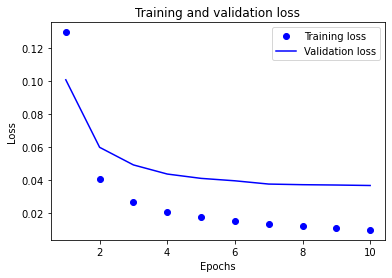

In [31]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

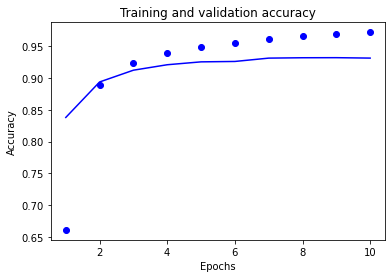

In [32]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

We load our best model

In [33]:
model = keras.models.load_model('simple_lstm.keras')

## Evaluation

### Formatting the Test Set

In [34]:
# In X_dict, we replace the words with their index
X_test_cat, Y_test_cat = build_sequences(test_dict)
# We create the parallel sequences of indexes
X_test_idx = to_index(X_test_cat, word_idx)
Y_test_idx = to_index(Y_test_cat, pos_idx)

print('X[0] test idx', X_test_idx[0])
print('Y[0] test idx', Y_test_idx[0])

X_test_padded = pad_sequences(X_test_idx, padding='post')
Y_test_padded = pad_sequences(Y_test_idx, padding='post')
print('X[0] test idx passed', X_test_padded[0])
print('Y[0] test idx padded', Y_test_padded[0])
# One extra symbol for 0 (padding)
Y_test_padded_vectorized = to_categorical(Y_test_padded, 
                                          num_classes=len(pos) + 2)
print('Y[0] test idx padded vectorized', Y_test_padded_vectorized[0])
print(X_test_padded.shape)
print(Y_test_padded_vectorized.shape)

X[0] test idx [388237, 187827, 165434, 251416, 193006, 1, 43464]
Y[0] test idx [12, 15, 13, 17, 3, 13, 14]
X[0] test idx passed [388237 187827 165434 251416 193006      1  43464      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0]
Y[0] test idx padded [12 15 13 17  3 13 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 

### Evaluation

In [35]:
# Evaluates with the padding symbol
test_loss, test_acc = model.evaluate(X_test_padded, 
                                     Y_test_padded_vectorized)
print('Loss:', test_loss)
print('Accuracy:', test_acc)

65/65 [==============================] - 4s 25ms/step - loss: 0.0303 - accuracy: 0.9379
Loss: 0.03031362034380436
Accuracy: 0.9379296898841858


We reach 93.50 with bidirectional LSTMs

### We evaluate on all the test corpus

X_test

In [36]:
X_test_cat[0]

['what', 'if', 'google', 'morphed', 'into', 'googleos', '?']

X_test_padded

In [37]:
X_test_padded[0]

array([388237, 187827, 165434, 251416, 193006,      1,  43464,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0], dtype=int32)

In [38]:
Y_test_probs_padded = model.predict(X_test_padded)

Y_test

In [39]:
Y_test_cat[0]

['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']

Y_test_padded

In [40]:
Y_test_padded[0]

array([12, 15, 13, 17,  3, 13, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

Y_test_probs

In [41]:
Y_test_probs_padded[0]

array([[4.0515602e-07, 4.8154141e-07, 1.4677826e-05, ..., 7.2799856e-04,
        3.1615500e-06, 5.6506869e-05],
       [3.3943370e-09, 3.9935379e-09, 1.3943644e-06, ..., 4.7358073e-04,
        2.4130362e-05, 2.1607586e-06],
       [2.0740086e-10, 4.0962386e-10, 2.8768892e-07, ..., 3.0237322e-03,
        8.9124384e-05, 2.0799791e-06],
       ...,
       [2.7593948e-02, 2.7523659e-02, 5.3513486e-02, ..., 5.2677248e-02,
        7.2272345e-02, 4.3936267e-02],
       [2.7593948e-02, 2.7523659e-02, 5.3513486e-02, ..., 5.2677248e-02,
        7.2272345e-02, 4.3936267e-02],
       [2.7593948e-02, 2.7523659e-02, 5.3513486e-02, ..., 5.2677248e-02,
        7.2272345e-02, 4.3936267e-02]], dtype=float32)

Y_test_hat

In [42]:
list(map(np.argmax, Y_test_probs_padded[0]))

[12,
 15,
 13,
 17,
 3,
 13,
 14,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18]

### Remove padding

In [43]:
Y_test_probs = []
for sent_nbr, y_test_probs_padded in enumerate(Y_test_probs_padded):
    Y_test_probs += [y_test_probs_padded[:len(X_test_cat[sent_nbr])]]
print(Y_test_probs[:1])

[array([[4.05156015e-07, 4.81541406e-07, 1.46778257e-05, 1.26897226e-06,
        1.48222758e-03, 8.42073132e-06, 1.04088313e-05, 4.89383331e-03,
        4.98318870e-04, 3.01006330e-05, 4.22648334e-08, 1.23018172e-05,
        9.91662264e-01, 7.00152759e-06, 1.12174530e-06, 5.89183299e-04,
        2.15653358e-07, 7.27998558e-04, 3.16155001e-06, 5.65068694e-05],
       [3.39433703e-09, 3.99353794e-09, 1.39436440e-06, 5.82009146e-04,
        9.99577896e-05, 8.47477233e-04, 2.23866846e-05, 2.55707477e-04,
        3.12966258e-05, 2.01629315e-04, 6.06215309e-08, 1.87960250e-05,
        1.03035663e-05, 7.65714387e-04, 1.65199541e-04, 9.96495068e-01,
        3.07423943e-06, 4.73580731e-04, 2.41303624e-05, 2.16075864e-06],
       [2.07400860e-10, 4.09623863e-10, 2.87688920e-07, 1.88595891e-06,
        3.02653789e-05, 1.30154949e-04, 7.19729712e-07, 3.26844713e-07,
        3.32924083e-06, 7.76147004e-04, 4.64017518e-07, 3.23594977e-05,
        4.02769219e-05, 9.95516360e-01, 2.62640640e-07, 3.445

### Convert POS indices to symbols

In [44]:
Y_test_cat_hat = []
for y_probs in Y_test_probs:
    y_idx = list(map(np.argmax, y_probs))
    y_cat_hat = list(map(idx_pos.get, y_idx))
    Y_test_cat_hat += [y_cat_hat]

print(Y_test_cat_hat[:2])
print(Y_test_cat[:2])

[['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT'], ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PRON', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'CCONJ', 'ADV', 'NOUN', 'PUNCT', 'NOUN', 'ADP', 'DET', 'ADJ', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']]
[['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT'], ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PRON', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'CCONJ', 'ADV', 'NOUN', 'PUNCT', 'NOUN', 'ADP', 'DET', 'ADV', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']]


### Evaluate

In [45]:
total, correct, total_ukn, correct_ukn = 0, 0, 0, 0
for id_s, x_test_cat in enumerate(X_test_cat):
    for id_w, word in enumerate(x_test_cat):
        total += 1
        if Y_test_cat_hat[id_s][id_w] == Y_test_cat[id_s][id_w]:
            correct += 1
        # The word is not in the dictionary
        if word not in word_idx:
            total_ukn += 1
            if Y_test_cat_hat[id_s][id_w] == Y_test_cat[id_s][id_w]:
                correct_ukn += 1

print('total %d, correct %d, accuracy %f' % 
      (total, correct, correct / total))
if total_ukn != 0:
    print('total unknown %d, correct %d, accuracy %f' % 
          (total_ukn, correct_ukn, correct_ukn / total_ukn))

total 25455, correct 23875, accuracy 0.937930
total unknown 489, correct 304, accuracy 0.621677


## Prediction of parts of speech

In [46]:
def predict_sentence(sentence, model, word_idx, 
                     vocabulary_words, idx_pos, verbose=False):
    # Predict one sentence
    sentence = sentence.split()
    word_idxs = to_index([sentence], word_idx)
    pos_idx_pred = model.predict(word_idxs)[0]
    pos_idxs = list(map(np.argmax, pos_idx_pred))
    pos = list(map(idx_pos.get, pos_idxs))
    if verbose:
        print('Sentence', sentence)
        print('Sentence word indexes', word_idxs)
        #print('Padded sentence', word_idx_padded)
        print('POS predicted', pos_idx_pred[0])
        print('POS shape', pos_idx_pred.shape)
    return pos

In [47]:
sentences = ['That round table might collapse .',
                 'The man can learn well .',
                 'The man can swim .',
                 'The man can simwo .']
for sentence in sentences:
    y_test_cat_hat = predict_sentence(sentence.lower(), 
                                       model, word_idx, 
                                       vocabulary_words, 
                                       idx_pos)
    print(sentence)
    print(y_test_cat_hat)

That round table might collapse .
['DET', 'ADJ', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can learn well .
['DET', 'NOUN', 'AUX', 'VERB', 'ADV', 'PUNCT']
The man can swim .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can simwo .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
